In [1]:
import sys, os
import torch
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from typing import Tuple

# scVI imports
import scvi
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE
from FactorVAE import FactorVAE, factorTrain



In [3]:
show_plot = True
test_mode = False
n_epochs_all = None
save_path = "data/"
torch.manual_seed(0)
np.random.seed(0)
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=60)

%matplotlib inline


In [4]:
adata = sc.read_10x_mtx(
    os.path.join(
        save_path, "filtered_gene_bc_matrices/hg19/"
    ),  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
)
adata.var_names_make_unique()

## Preprocessing
In the following section, we reproduce the preprocessing steps adopted in the scanpy notebook.

Basic filtering: we remove cells with a low number of genes expressed and genes which are expressed in a low number of cells.

In [5]:
def if_not_test_else(x, y):
    if not test_mode:
        return x
    else:
        return y

min_genes = if_not_test_else(200, 0)
min_cells = if_not_test_else(3, 0)

In [6]:
sc.settings.verbosity = 2
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_genes(adata, min_cells=min_cells)
sc.pp.filter_cells(adata, min_genes=1)

filtered out 19024 genes that are detected in less than 3 cells


#### As in the scanpy notebook, we then look for high levels of mitochondrial genes and high number of expressed genes which are indicators of poor quality cells.

In [7]:
mito_genes = adata.var_names.str.startswith("MT-")
adata.obs["percent_mito"] = (
    np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
)
adata.obs["n_counts"] = adata.X.sum(axis=1).A1

In [8]:
adata = adata[adata.obs["n_genes"] < 2500, :]
adata = adata[adata.obs["percent_mito"] < 0.05, :]

We only keep highly variable genes

In [9]:
adata_original = adata.copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


min_mean = if_not_test_else(0.0125, -np.inf)
max_mean = if_not_test_else(3, np.inf)
min_disp = if_not_test_else(0.5, -np.inf)
max_disp = if_not_test_else(None, np.inf)

sc.pp.highly_variable_genes(
    adata,
    min_mean=min_mean,
    max_mean=max_mean,
    min_disp=min_disp,
    max_disp=max_disp
)

highly_variable_genes = adata.var["highly_variable"]
adata = adata[:, highly_variable_genes]

adata.raw = adata

sc.pp.regress_out(adata, ["n_counts", "percent_mito"])
sc.pp.scale(adata, max_value=10)

# Also filter the original adata genes
adata_original = adata_original[:, highly_variable_genes]
print("{} highly variable genes".format(highly_variable_genes.sum()))

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)
1838 highly variable genes


In [10]:
def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 5,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
) -> Tuple[scvi.inference.Posterior, np.ndarray]:
    """Train and return a scVI model and sample a latent space

    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    scviDataset = AnnDatasetFromAnnData(adata)

    # Train a model
    vae = FactorVAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_latent=n_latent,
    )
    trainer = factorTrain(vae, scviDataset, train_size=1.0, use_cuda=use_cuda)
    trainer.train(n_epochs=n_epochs, lr=lr)
    ####

    # Extract latent space
    posterior = trainer.create_posterior(
        trainer.model, scviDataset, indices=np.arange(len(scviDataset))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent

In [11]:
n_epochs = 50 if n_epochs_all is None else n_epochs_all

# use_cuda to use GPU
use_cuda = False

scvi_posterior, scvi_latent = compute_scvi_latent(
    adata_original, n_epochs=n_epochs, n_latent=10, use_cuda=use_cuda
)
adata.obsm["X_scvi"] = scvi_latent

# store scvi imputed expression
scale = scvi_posterior.get_sample_scale()
for _ in range(9):
    scale += scvi_posterior.get_sample_scale()
scale /= 10

for gene, gene_scale in zip(adata.var.index, np.squeeze(scale).T):
    adata.obs["scale_" + gene] = gene_scale

[2020-04-26 15:23:41,567] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-04-26 15:23:41,592] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-26 15:23:41,595] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-26 15:23:41,660] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-26 15:23:41,671] INFO - scvi.dataset.dataset | Downsampled from 2638 to 2638 cells
model n latent 10
[2020-04-26 15:23:41,714] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-04-26 15:23:41,715] INFO - scvi.inference.inference | KL warmup for 400 epochs


VAE loss 1957.7655029296875, Discriminator loss 0.0002627553476486355
VAE loss 2009.5103759765625, Discriminator loss 0.00026275479467585683
VAE loss 1810.6273193359375, Discriminator loss 0.00026275470736436546
VAE loss 1770.005126953125, Discriminator loss 0.00026275429991073906
VAE loss 1891.4742431640625, Discriminator loss 0.0002627542708069086
VAE loss 1786.8343505859375, Discriminator loss 0.00026275409618392587
VAE loss 1681.4393310546875, Discriminator loss 0.00026275429991073906
VAE loss 1808.1409912109375, Discriminator loss 0.0002627532812766731
VAE loss 1747.5904541015625, Discriminator loss 0.0002627513313200325
VAE loss 1743.70947265625, Discriminator loss 0.00026275176787748933
VAE loss 1683.400634765625, Discriminator loss 0.0002627488865982741
VAE loss 1625.339599609375, Discriminator loss 0.00026274865376763046
VAE loss 1547.3431396484375, Discriminator loss 0.00026274833362549543
VAE loss 1554.2578125, Discriminator loss 0.0002627440553624183
VAE loss 1566.468994140

VAE loss 585.2457275390625, Discriminator loss 0.0002513908257242292
VAE loss 574.713134765625, Discriminator loss 0.0002495650842320174
VAE loss 567.2161865234375, Discriminator loss 0.0002494301297701895
VAE loss 575.166259765625, Discriminator loss 0.00024783617118373513
VAE loss 567.6339721679688, Discriminator loss 0.00024820014368742704
VAE loss 590.3461303710938, Discriminator loss 0.00024802295956760645
VAE loss 552.521484375, Discriminator loss 0.0002449938328936696
VAE loss 585.97119140625, Discriminator loss 0.0002454514615237713
VAE loss 576.8316040039062, Discriminator loss 0.00024462476721964777
VAE loss 558.3467407226562, Discriminator loss 0.00024309309083037078
VAE loss 593.5245971679688, Discriminator loss 0.00024366365687455982
VAE loss 591.5225219726562, Discriminator loss 0.00024284992832690477
VAE loss 589.1961059570312, Discriminator loss 0.00024415142252109945
VAE loss 585.6823120117188, Discriminator loss 0.00024051462241914123
VAE loss 569.3109130859375, Discr

VAE loss 550.2620849609375, Discriminator loss 0.00013172916078474373
VAE loss 583.220458984375, Discriminator loss 0.00011266903311479837
VAE loss 579.1939697265625, Discriminator loss 0.0001043129523168318
VAE loss 539.300537109375, Discriminator loss 0.00012342676927801222
VAE loss 557.5191650390625, Discriminator loss 0.00011438239744165912
VAE loss 531.4598388671875, Discriminator loss 0.00010197191295446828
VAE loss 598.7306518554688, Discriminator loss 0.00011274001735728234
VAE loss 535.6848754882812, Discriminator loss 9.567043889546767e-05
VAE loss 576.1296997070312, Discriminator loss 9.562668128637597e-05
VAE loss 568.4287719726562, Discriminator loss 8.706175140105188e-05
VAE loss 553.7638549804688, Discriminator loss 8.796337351668626e-05
VAE loss 580.2137451171875, Discriminator loss 0.00013659830437973142
VAE loss 520.5426635742188, Discriminator loss 0.00010494728485355154
VAE loss 566.15771484375, Discriminator loss 0.00011224539775867015
VAE loss 546.9555053710938, D

VAE loss 559.851806640625, Discriminator loss 0.00010928380652330816
VAE loss 537.3806762695312, Discriminator loss 0.00011744794755941257
VAE loss 563.9815063476562, Discriminator loss 0.00010494577145436779
VAE loss 535.791748046875, Discriminator loss 0.00012101868924219161
VAE loss 532.4638671875, Discriminator loss 9.802704880712554e-05
VAE loss 533.1943359375, Discriminator loss 0.00013857291196472943
VAE loss 564.7763671875, Discriminator loss 0.00015773269115015864
VAE loss 549.2028198242188, Discriminator loss 8.943715511122718e-05
VAE loss 519.8309326171875, Discriminator loss 0.00013701307761948556
VAE loss 555.1935424804688, Discriminator loss 0.00011603865277720615
VAE loss 546.5712280273438, Discriminator loss 0.00012491423694882542
VAE loss 521.141845703125, Discriminator loss 0.00012606647214852273
VAE loss 579.8267211914062, Discriminator loss 0.00011496017395984381
VAE loss 549.608642578125, Discriminator loss 0.00015829024778213352
VAE loss 541.4352416992188, Discrim

VAE loss 526.06884765625, Discriminator loss 0.00014563380682375282
VAE loss 538.3797607421875, Discriminator loss 0.0001559929660288617
VAE loss 517.8410034179688, Discriminator loss 0.00012813814100809395
VAE loss 568.8734741210938, Discriminator loss 0.0001430468837497756
VAE loss 522.7560424804688, Discriminator loss 0.00013321448932401836
VAE loss 521.6624145507812, Discriminator loss 0.00015303368854802102
VAE loss 550.9046630859375, Discriminator loss 0.00013931967259850353
VAE loss 508.33544921875, Discriminator loss 0.00013381447934079915
VAE loss 546.2183227539062, Discriminator loss 0.00011161640577483922
VAE loss 542.7601928710938, Discriminator loss 0.00013857429439667612
VAE loss 508.69940185546875, Discriminator loss 0.00013299293641466647
VAE loss 528.8076782226562, Discriminator loss 0.00014287720841821283
VAE loss 538.0947265625, Discriminator loss 0.00011868993169628084
VAE loss 537.97265625, Discriminator loss 0.00014414623728953302
VAE loss 532.7929077148438, Discr

VAE loss 550.6617431640625, Discriminator loss 0.00011325955711072311
VAE loss 535.1820678710938, Discriminator loss 0.00014875901979394257
VAE loss 548.68017578125, Discriminator loss 0.00014654544065706432
VAE loss 564.7753295898438, Discriminator loss 0.00012587913079187274
VAE loss 529.5147094726562, Discriminator loss 0.00015586218796670437
VAE loss 532.8271484375, Discriminator loss 0.00015856631216593087
VAE loss 533.0596313476562, Discriminator loss 0.0001415151491528377
VAE loss 538.02001953125, Discriminator loss 0.00014216647832654417
VAE loss 532.8640747070312, Discriminator loss 0.0001665501476963982
VAE loss 555.9026489257812, Discriminator loss 0.00015846523456275463
VAE loss 531.061767578125, Discriminator loss 0.00014897942310199142
VAE loss 522.2068481445312, Discriminator loss 0.0001223772851517424
VAE loss 517.1036376953125, Discriminator loss 0.00013930581917520612
VAE loss 504.2095947265625, Discriminator loss 0.0001410334516549483
VAE loss 538.48876953125, Discri

VAE loss 525.2215576171875, Discriminator loss 0.00016007311933208257
VAE loss 509.3583679199219, Discriminator loss 0.00017309258691966534
VAE loss 509.7110900878906, Discriminator loss 0.00018188526155427098
VAE loss 526.9692993164062, Discriminator loss 0.00015393704234156758
VAE loss 526.7998657226562, Discriminator loss 0.00016059608606155962
VAE loss 529.0036010742188, Discriminator loss 0.00014781532809138298
VAE loss 501.2344665527344, Discriminator loss 0.00012505716586019844
VAE loss 536.9705200195312, Discriminator loss 0.00015501634334214032
VAE loss 533.8265380859375, Discriminator loss 0.00014959863619878888
VAE loss 532.8712158203125, Discriminator loss 0.00018502690363675356
VAE loss 543.3826904296875, Discriminator loss 0.00013538679922930896
VAE loss 505.2541198730469, Discriminator loss 0.0001578970841364935
VAE loss 520.3217163085938, Discriminator loss 0.000148497405461967
VAE loss 497.9786682128906, Discriminator loss 0.00013192155165597796
VAE loss 541.708984375,

VAE loss 511.64154052734375, Discriminator loss 0.00015034213720355183
VAE loss 507.8023986816406, Discriminator loss 0.00016390986274927855
VAE loss 531.9691772460938, Discriminator loss 0.00018334054038859904
VAE loss 529.3682861328125, Discriminator loss 0.00015789498866070062
VAE loss 525.2808227539062, Discriminator loss 0.00015761010581627488
VAE loss 503.7000427246094, Discriminator loss 0.00016698894614819437
VAE loss 511.88616943359375, Discriminator loss 0.00014463276602327824
VAE loss 498.82879638671875, Discriminator loss 0.00014390924479812384
VAE loss 497.83160400390625, Discriminator loss 0.00014998529513832182
VAE loss 521.6765747070312, Discriminator loss 0.00014046095020603389
VAE loss 517.7830810546875, Discriminator loss 0.00014988119073677808
VAE loss 561.05029296875, Discriminator loss 0.00013413421402219683
VAE loss 500.7754821777344, Discriminator loss 0.0001630795595701784
VAE loss 521.8494873046875, Discriminator loss 0.0001672748039709404
VAE loss 522.9144897

VAE loss 495.53985595703125, Discriminator loss 0.00015962152974680066
VAE loss 513.2195434570312, Discriminator loss 0.0001546186686027795
VAE loss 531.0538940429688, Discriminator loss 0.00016985443653538823
VAE loss 523.1806030273438, Discriminator loss 0.00016430785763077438
VAE loss 503.2920837402344, Discriminator loss 0.00016337160195689648
VAE loss 532.2060546875, Discriminator loss 0.0001453462173230946
VAE loss 527.031005859375, Discriminator loss 0.00015331136819440871
VAE loss 529.3211059570312, Discriminator loss 0.00014009667211212218
VAE loss 516.733154296875, Discriminator loss 0.0001686164760030806
VAE loss 499.5291442871094, Discriminator loss 0.00019738933769986033
VAE loss 507.3721618652344, Discriminator loss 0.0001548037980683148
VAE loss 521.7100830078125, Discriminator loss 0.0001414749276591465
VAE loss 502.6408386230469, Discriminator loss 0.0001724678440950811
VAE loss 523.0045776367188, Discriminator loss 0.00014429357543122023
VAE loss 529.9843139648438, Di

In [12]:
sc.tl.pca(adata, svd_solver="arpack")

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)


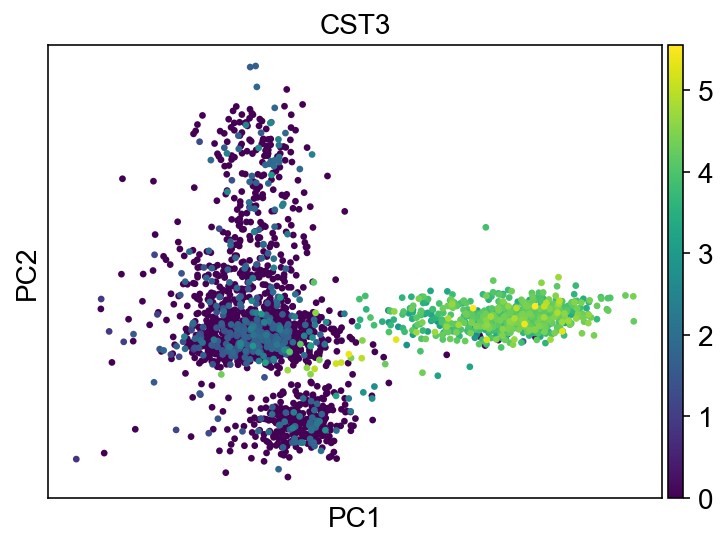

In [13]:
sc.pl.pca(adata, color="CST3", show=show_plot)

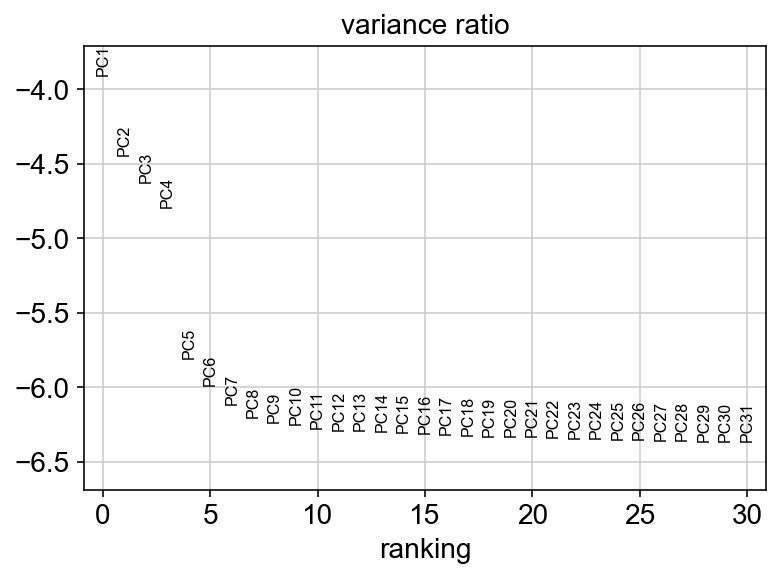

In [14]:
sc.pl.pca_variance_ratio(adata, log=True, show=show_plot)

In [16]:
from typing import Tuple

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, key_added="leiden_pca")
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:04)


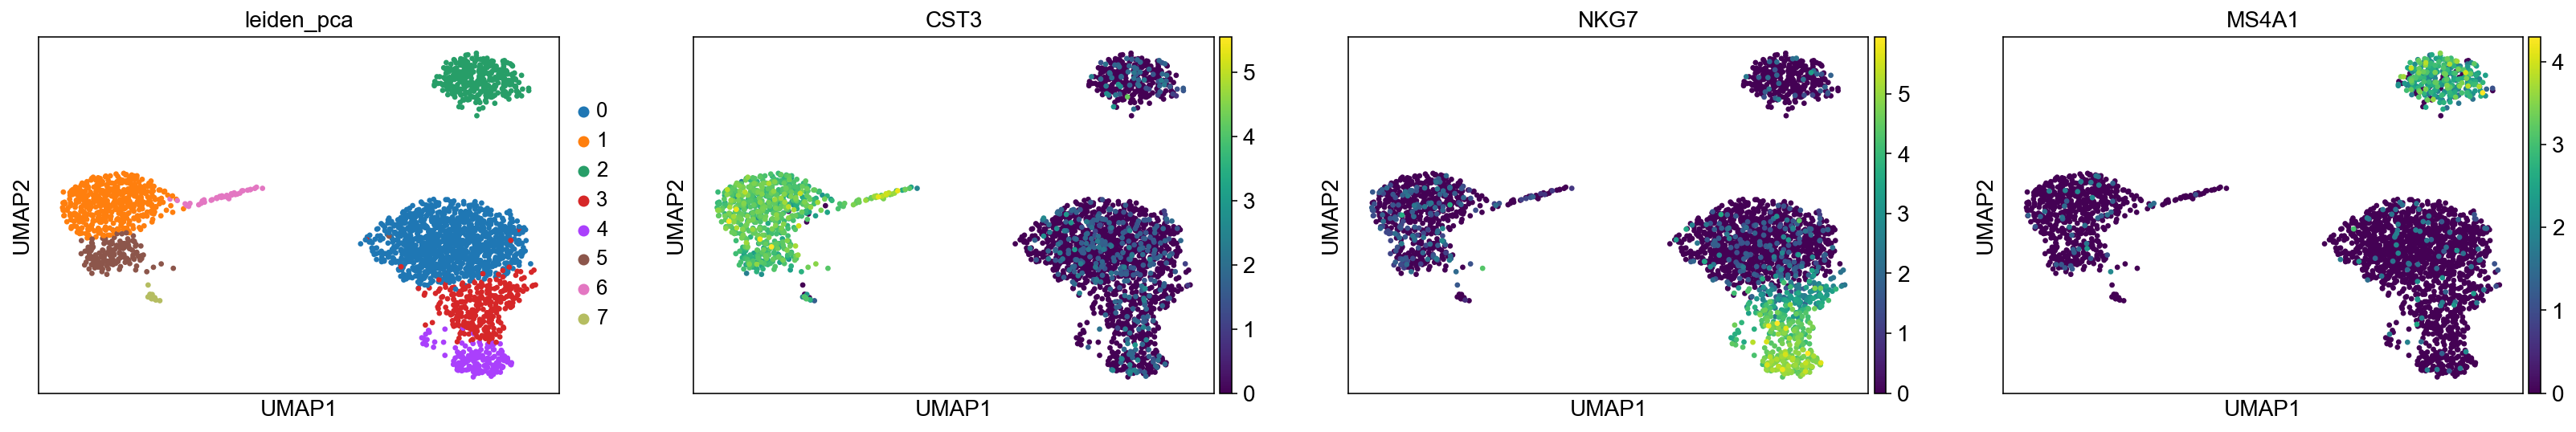

In [17]:
sc.pl.umap(adata, color=["leiden_pca", "CST3", "NKG7", "MS4A1"], ncols=4, show=show_plot)

In [18]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40, use_rep="X_scvi")
sc.tl.umap(adata)

computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:05)


In [19]:
sc.tl.leiden(adata, key_added="leiden_scvi", resolution=0.8)

running Leiden clustering
    finished (0:00:00)


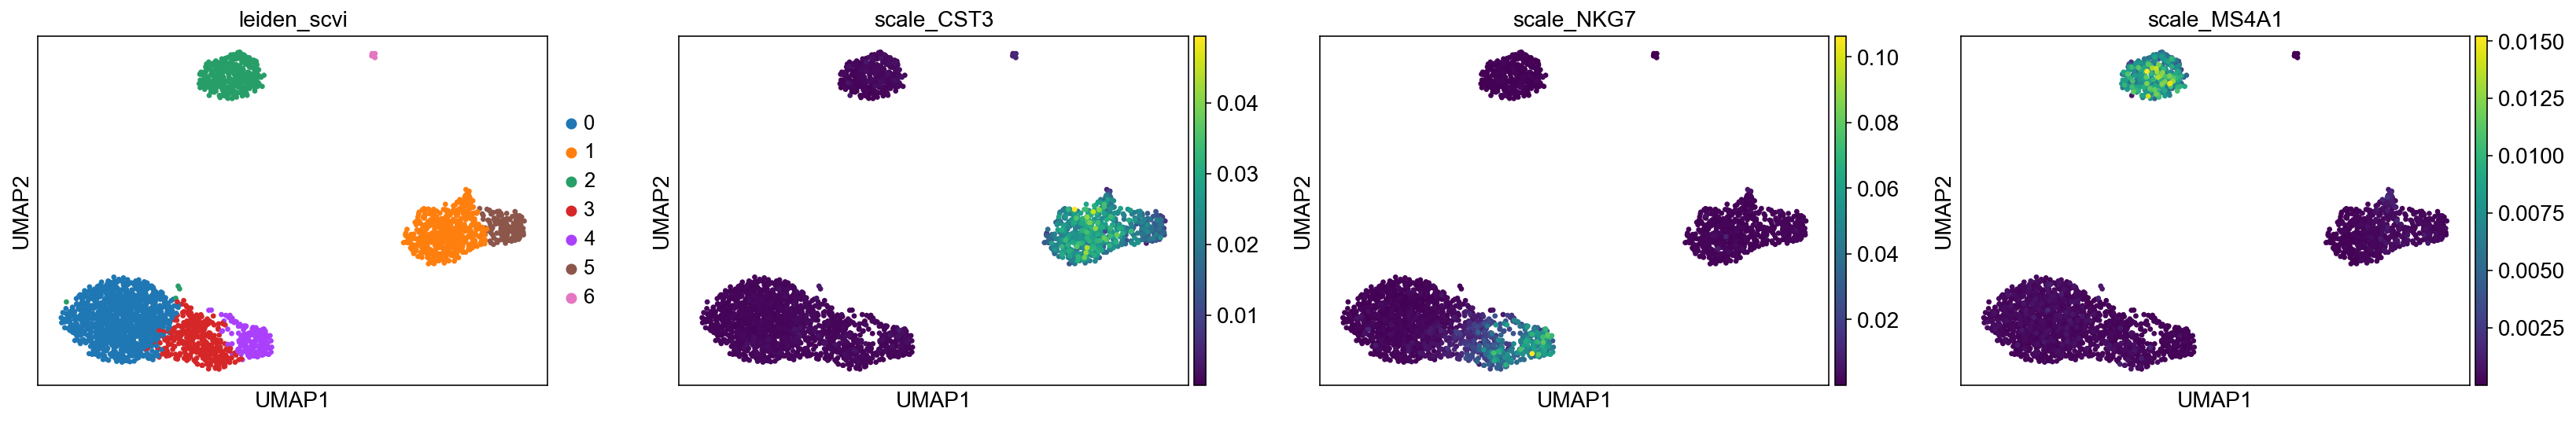

In [20]:
sc.pl.umap(adata, color=["leiden_scvi", "scale_CST3", "scale_NKG7", "scale_MS4A1"], ncols=4, show=show_plot)

In [24]:
adata.obsm["X_scvi"][0, :]

array([-1.9004699 ,  0.13298884, -0.42434198, -0.11628431, -0.53207475,
        0.28380388, -0.29919815,  1.4174051 , -1.3455079 , -0.9877177 ],
      dtype=float32)

In [32]:
from scipy.stats import pearsonr
from numpy import cov
latent = adata.obsm["X_scvi"].T
print(latent.shape)
corr = cov(latent)
corr.shape

(10, 2638)


(10, 10)

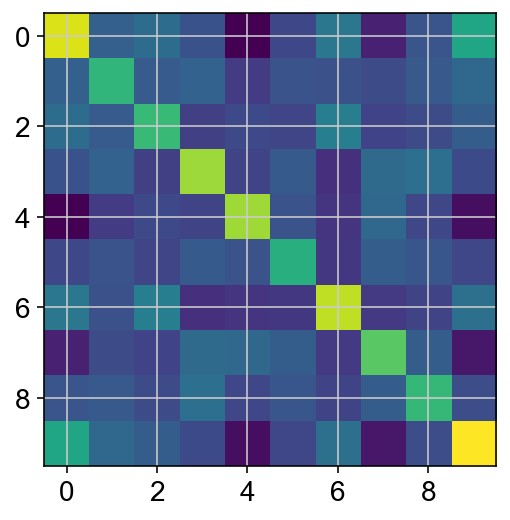

In [33]:
import matplotlib.pyplot as plt
plt.imshow(corr)
plt.show()